# Bi objetive NRP

In previous blog post we have explored the NRP (next release problem) which aims to determine which requierement should be implemented in the next release of a product, satisfying stakeholders' needs below a certaing cost.

But this approach seems to be quite restrictive. What if we want a solution for more than one objective? Could we find the optimum point for more than one objective?

In this post we explore how to extend the NRP problem for more than one objetive and a technique to find the solutions. 


## Formal definition
The model is exactly the same as before, but now the cost constraint is an objetive function. So now the objetive functions are

1) Maximize profit
$$
max \ f(Y) = \sum_{i \in S} b_i \cdot y_i
$$

2) Minimize costs
$$
min \ g(X) = \sum_{j \in R} c_j \cdot x_j 
$$

All other constraints and parameters stay the same

## $\epsilon$-restrictions method 

Now we need a way to solve the model and find solutions. In this blog, we'll use the $\epsilon$-restrictions methods. Long story short, we  maximize $f$ and use $g$ as a restriction

$$
g(X) < \epsilon
$$

By changing the value of $\epsilon$ we get different points. This points belong to a set of  points called [Pareto optimal front](https://en.wikipedia.org/wiki/Multi-objective_optimization#Solution)

### Implementing $\epsilon$-restrictions method in python
First, we create the same model used in a previous blog.

In [6]:
import pyomo.environ as pyo
from pyomo.environ import AbstractModel

# Create and abstract model
nrp_abs = pyo.AbstractModel()

# Assign parameters to the model
nrp_abs.number_of_requierements = pyo.Param(within=pyo.NonNegativeIntegers)
nrp_abs.number_of_costumers = pyo.Param(within=pyo.NonNegativeIntegers)
nrp_abs.max_cost = pyo.Param(within=pyo.NonNegativeIntegers, mutable=True)

# Sets used to maintain data of customers and requeriments
nrp_abs.requierements = pyo.RangeSet(1, nrp_abs.number_of_requierements)
nrp_abs.customers = pyo.RangeSet(1, nrp_abs.number_of_costumers)


# Parameters for the model
nrp_abs.profit = pyo.Param(nrp_abs.customers)  # Profit of each customer if it is satisfied
nrp_abs.cost = pyo.Param(nrp_abs.requierements)  # Cost of implementing each requierement


# (i,j) requierement i should be implemented if j is implemented
# Set is within the cross product of Requierements X Requierements
nrp_abs.prerequisite = pyo.Set(within=nrp_abs.requierements * nrp_abs.requierements)
# (i,k) this relation exists if stakeholder k has interest on requierement i
nrp_abs.interest = pyo.Set(within=nrp_abs.customers * nrp_abs.requierements)

# Creation of variables
# x = 1 if requierement i is implemented in the next release, otherwise 0
nrp_abs.x = pyo.Var(nrp_abs.requierements, domain=pyo.Binary)
# y = 1 if all customer requierements are satisfied in the next release, otherwise 0
nrp_abs.y = pyo.Var(nrp_abs.customers, domain=pyo.Binary)

# Objetive function
def obj_expression(nrp: AbstractModel):
    # Model should maximize profit of the next release
    return pyo.summation(nrp.profit, nrp.y)
nrp_abs.OBJ = pyo.Objective(rule=obj_expression, sense=pyo.maximize)


# Defintion of cost constraint rule
def cost_constraint_rule(nrp: AbstractModel):
    # Cost should be maintened under a predefined cost
    return pyo.summation(nrp.cost, nrp.x) <= nrp.max_cost
nrp_abs.cost_constraint = pyo.Constraint(rule=cost_constraint_rule)


# Defition of precedence constraint
def precedence_constraint_rule(nrp: AbstractModel, i: int, j: int):
    return nrp.x[i] >= nrp.x[j]
nrp_abs.precedence_constraint = pyo.Constraint(nrp_abs.prerequisite, rule=precedence_constraint_rule)

# Definition of interest constraint
# Each tuple in nrp.dat.interest is inverted, so the constraint is also inverted
def interest_constraint_rule(nrp: AbstractModel, i: int, k: int):
    return nrp.y[i] <= nrp.x[k]
nrp_abs.interest_constraint = pyo.Constraint(nrp_abs.interest, rule=interest_constraint_rule)

Because we've decalred `max_cost` as mutable, we can create the model with the data file, and make a for loop
which will change the `max_cost` and  solve it. 

In [27]:
from pyomo.environ import SolverFactory

data_file_path = '../datasets/nrp_100c_140r.dat'
nrp_concrete = nrp_abs.create_instance(data_file_path)
solver = SolverFactory('cbc')

results = {'cost':[], 'profit':[]}

for cost in range(0,300):
    nrp_concrete.max_cost = cost
    solver.solve(nrp_concrete)
    profit = nrp_concrete.OBJ.expr()
    
    results['cost'].append(cost)
    results['profit'].append(profit)

Now, we can go a little further and plot the pareto front using python's libraries

<AxesSubplot:xlabel='cost', ylabel='profit'>

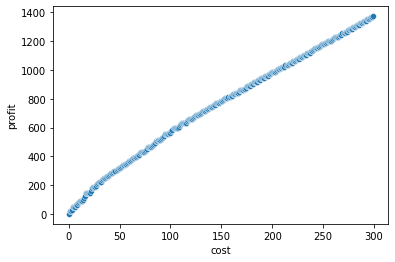

In [28]:
import pandas as pd
import seaborn as sns

df = pd.DataFrame.from_dict(results)
sns.scatterplot(data=df, x='cost', y='profit')